In [2]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# 1. Import Libraries

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
     BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier

from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib


# 2. Load Data

In [4]:
data = pd.read_csv('../Dataset/train.csv').dropna()
data

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.465380,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.465380,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.465380,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.465380,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.465380,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,155625,37932,4,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,34.663572,378.0,No,35.104023,24.028477,High_spent_Large_value_payments,479.866228,Poor
99996,155626,37932,5,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,40.565631,379.0,No,35.104023,24.028477,High_spent_Medium_value_payments,496.651610,Poor
99997,155627,37932,6,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,155628,37932,7,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,33.638208,381.0,No,35.104023,24.028477,Low_spent_Large_value_payments,319.164979,Standard


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,100000.0,8.063150e+04,4.330149e+04,5634.000000,4.313275e+04,8.063150e+04,1.181302e+05,1.556290e+05
Customer_ID,100000.0,2.598267e+04,1.434054e+04,1006.000000,1.366450e+04,2.577700e+04,3.838500e+04,5.099900e+04
Month,100000.0,4.500000e+00,2.291299e+00,1.000000,2.750000e+00,4.500000e+00,6.250000e+00,8.000000e+00
Age,100000.0,3.331634e+01,1.076481e+01,14.000000,2.400000e+01,3.300000e+01,4.200000e+01,5.600000e+01
SSN,100000.0,5.004617e+08,2.908267e+08,81349.000000,2.451686e+08,5.006886e+08,7.560027e+08,9.999934e+08
Annual_Income,100000.0,5.050512e+04,3.829942e+04,7005.930000,1.934297e+04,3.699971e+04,7.168347e+04,1.799873e+05
Monthly_Inhand_Salary,100000.0,4.197271e+03,3.186432e+03,303.645417,1.626594e+03,3.095905e+03,5.957715e+03,1.520463e+04
Num_Bank_Accounts,100000.0,5.368820e+00,2.593314e+00,0.000000,3.000000e+00,5.000000e+00,7.000000e+00,1.100000e+01
Num_Credit_Card,100000.0,5.533570e+00,2.067098e+00,0.000000,4.000000e+00,5.000000e+00,7.000000e+00,1.100000e+01
Interest_Rate,100000.0,1.453208e+01,8.741330e+00,1.000000,7.000000e+00,1.300000e+01,2.000000e+01,3.400000e+01


In [16]:
data.isnull().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

In [23]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Get columns dtypes

In [5]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['ID', 'Customer_ID', 'Month', 'Age', 'SSN', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
Categorical Columns : ['Name', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']


In [6]:
# data['Type_of_Loan_Root'] = [loan[0] for loan in data['Type_of_Loan'].str.split(',')]
data

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.465380,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.465380,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.465380,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.465380,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.465380,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,155625,37932,4,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,34.663572,378.0,No,35.104023,24.028477,High_spent_Large_value_payments,479.866228,Poor
99996,155626,37932,5,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,40.565631,379.0,No,35.104023,24.028477,High_spent_Medium_value_payments,496.651610,Poor
99997,155627,37932,6,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,155628,37932,7,Nicks,25.0,78735990.0,Mechanic,39628.99,3359.415833,4.0,...,Good,502.38,33.638208,381.0,No,35.104023,24.028477,Low_spent_Large_value_payments,319.164979,Standard


### 3.3. EDA

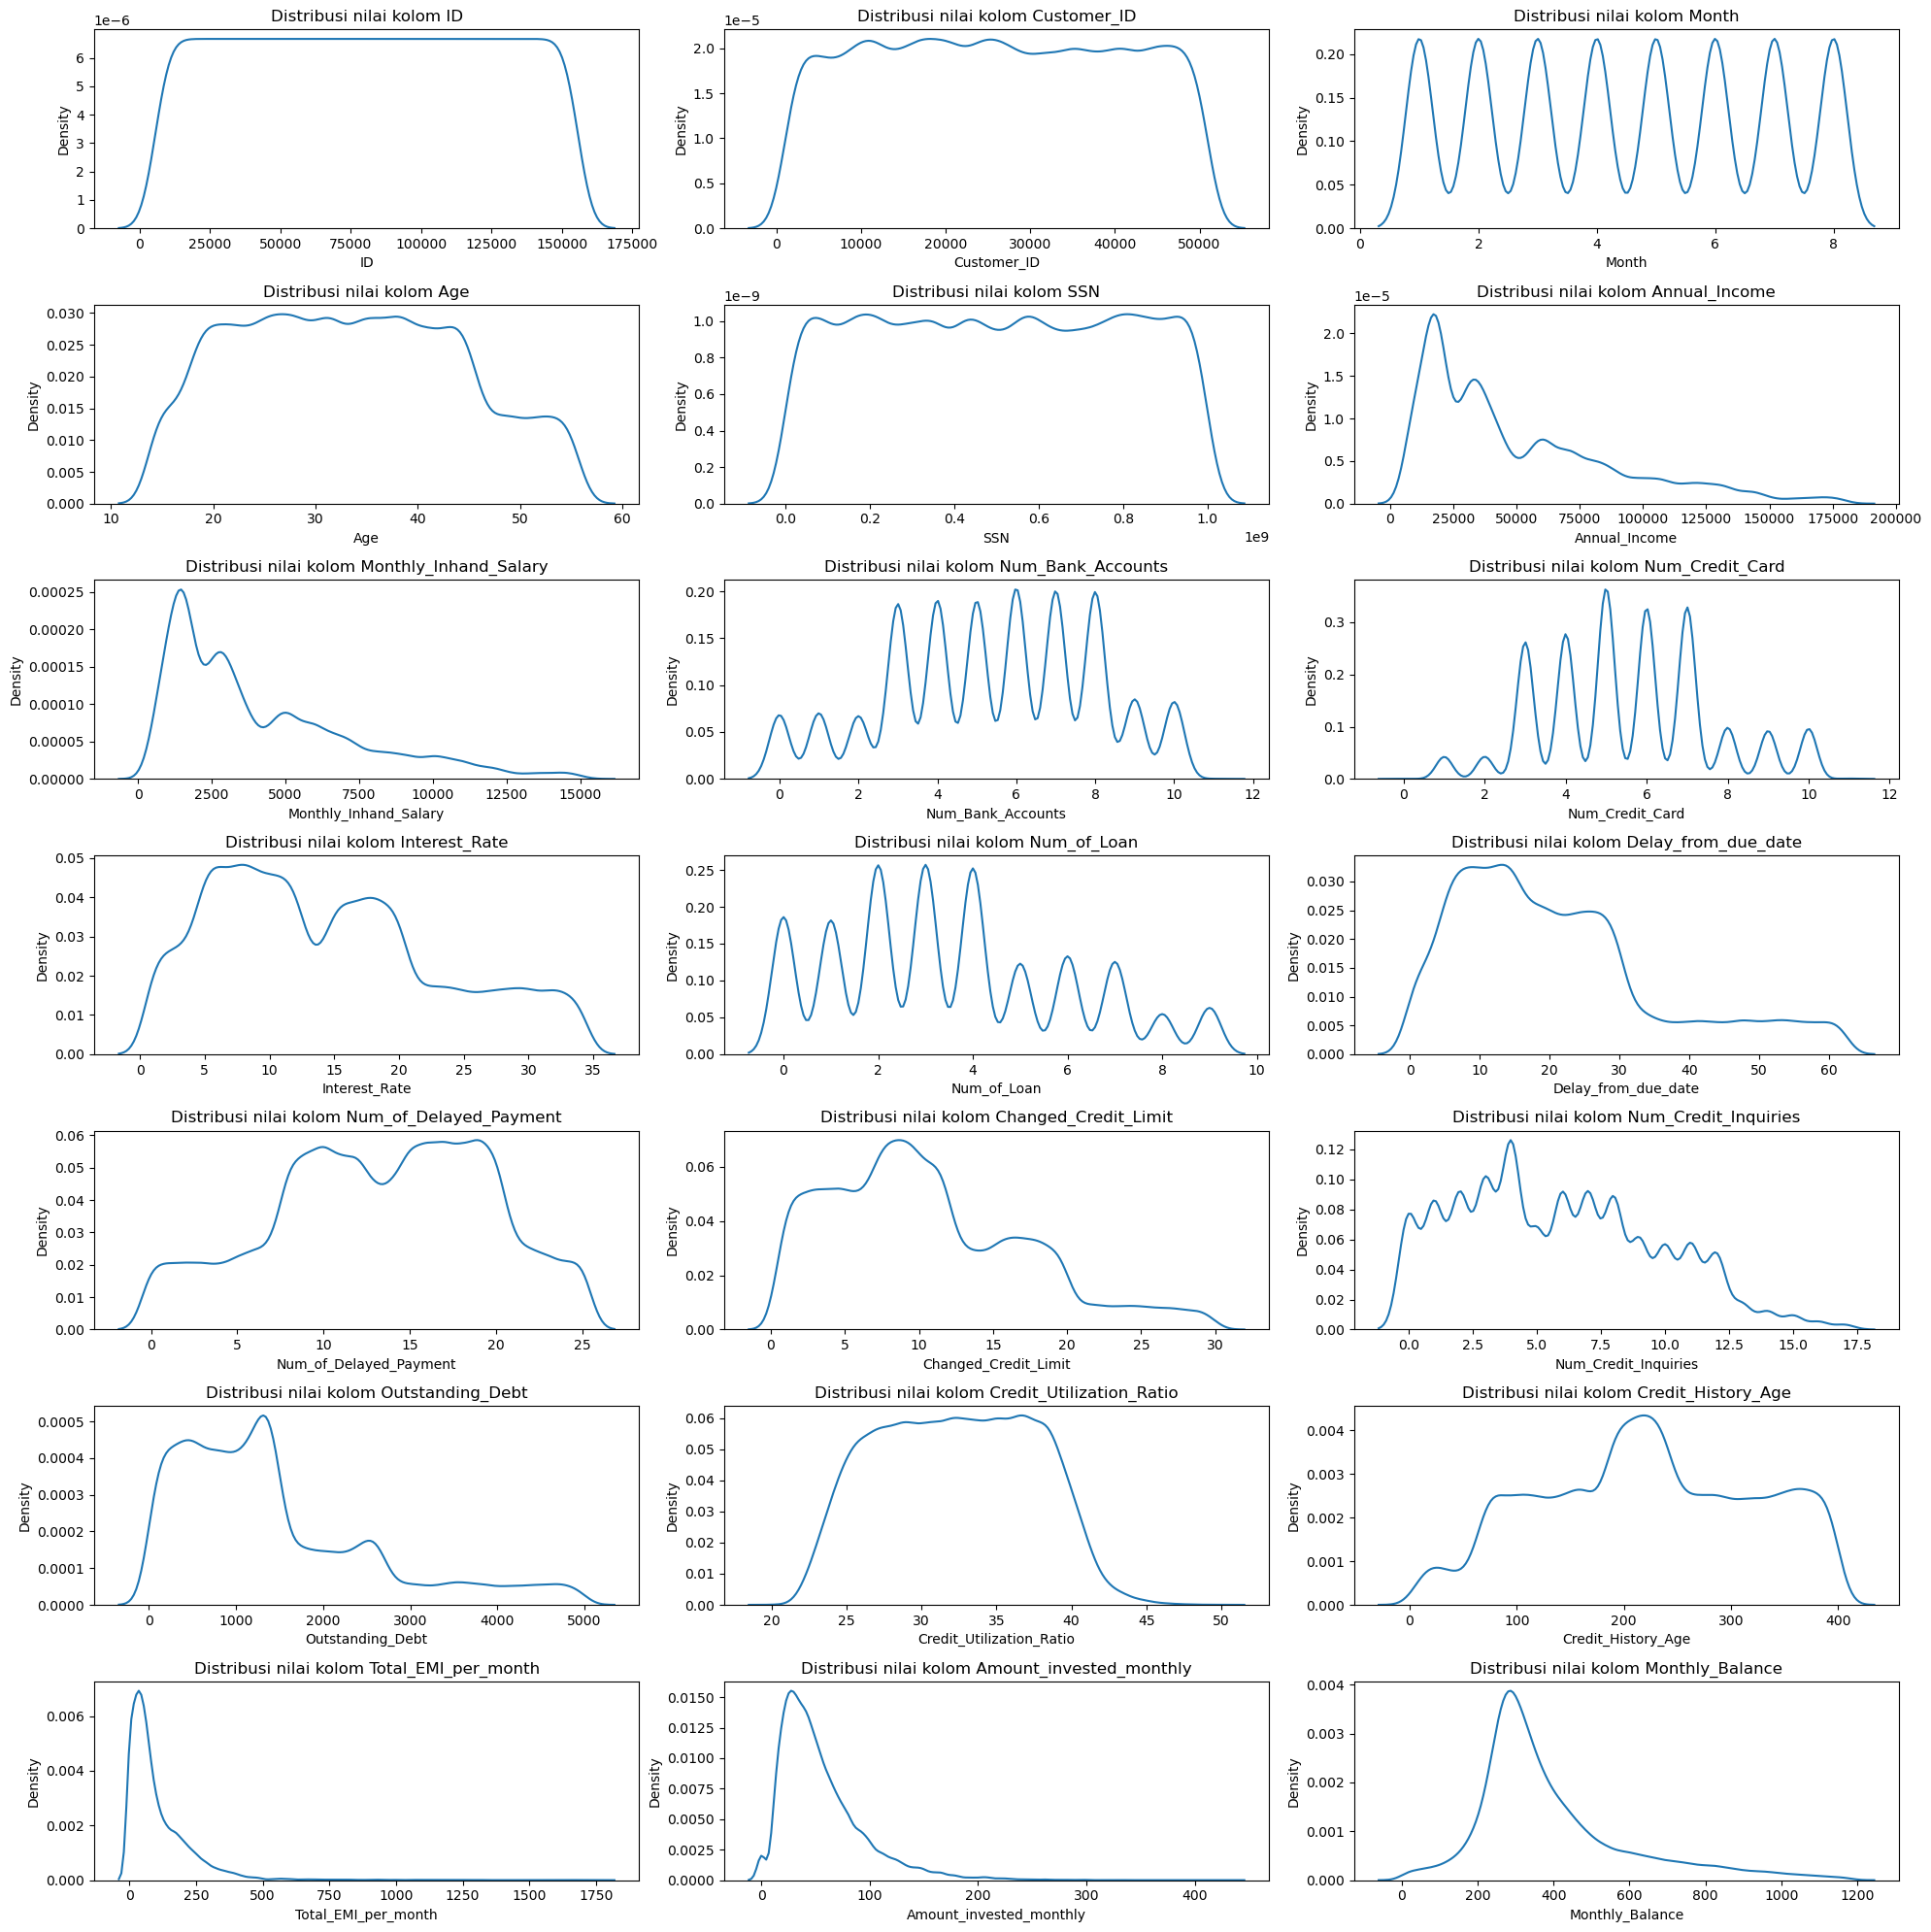

In [7]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

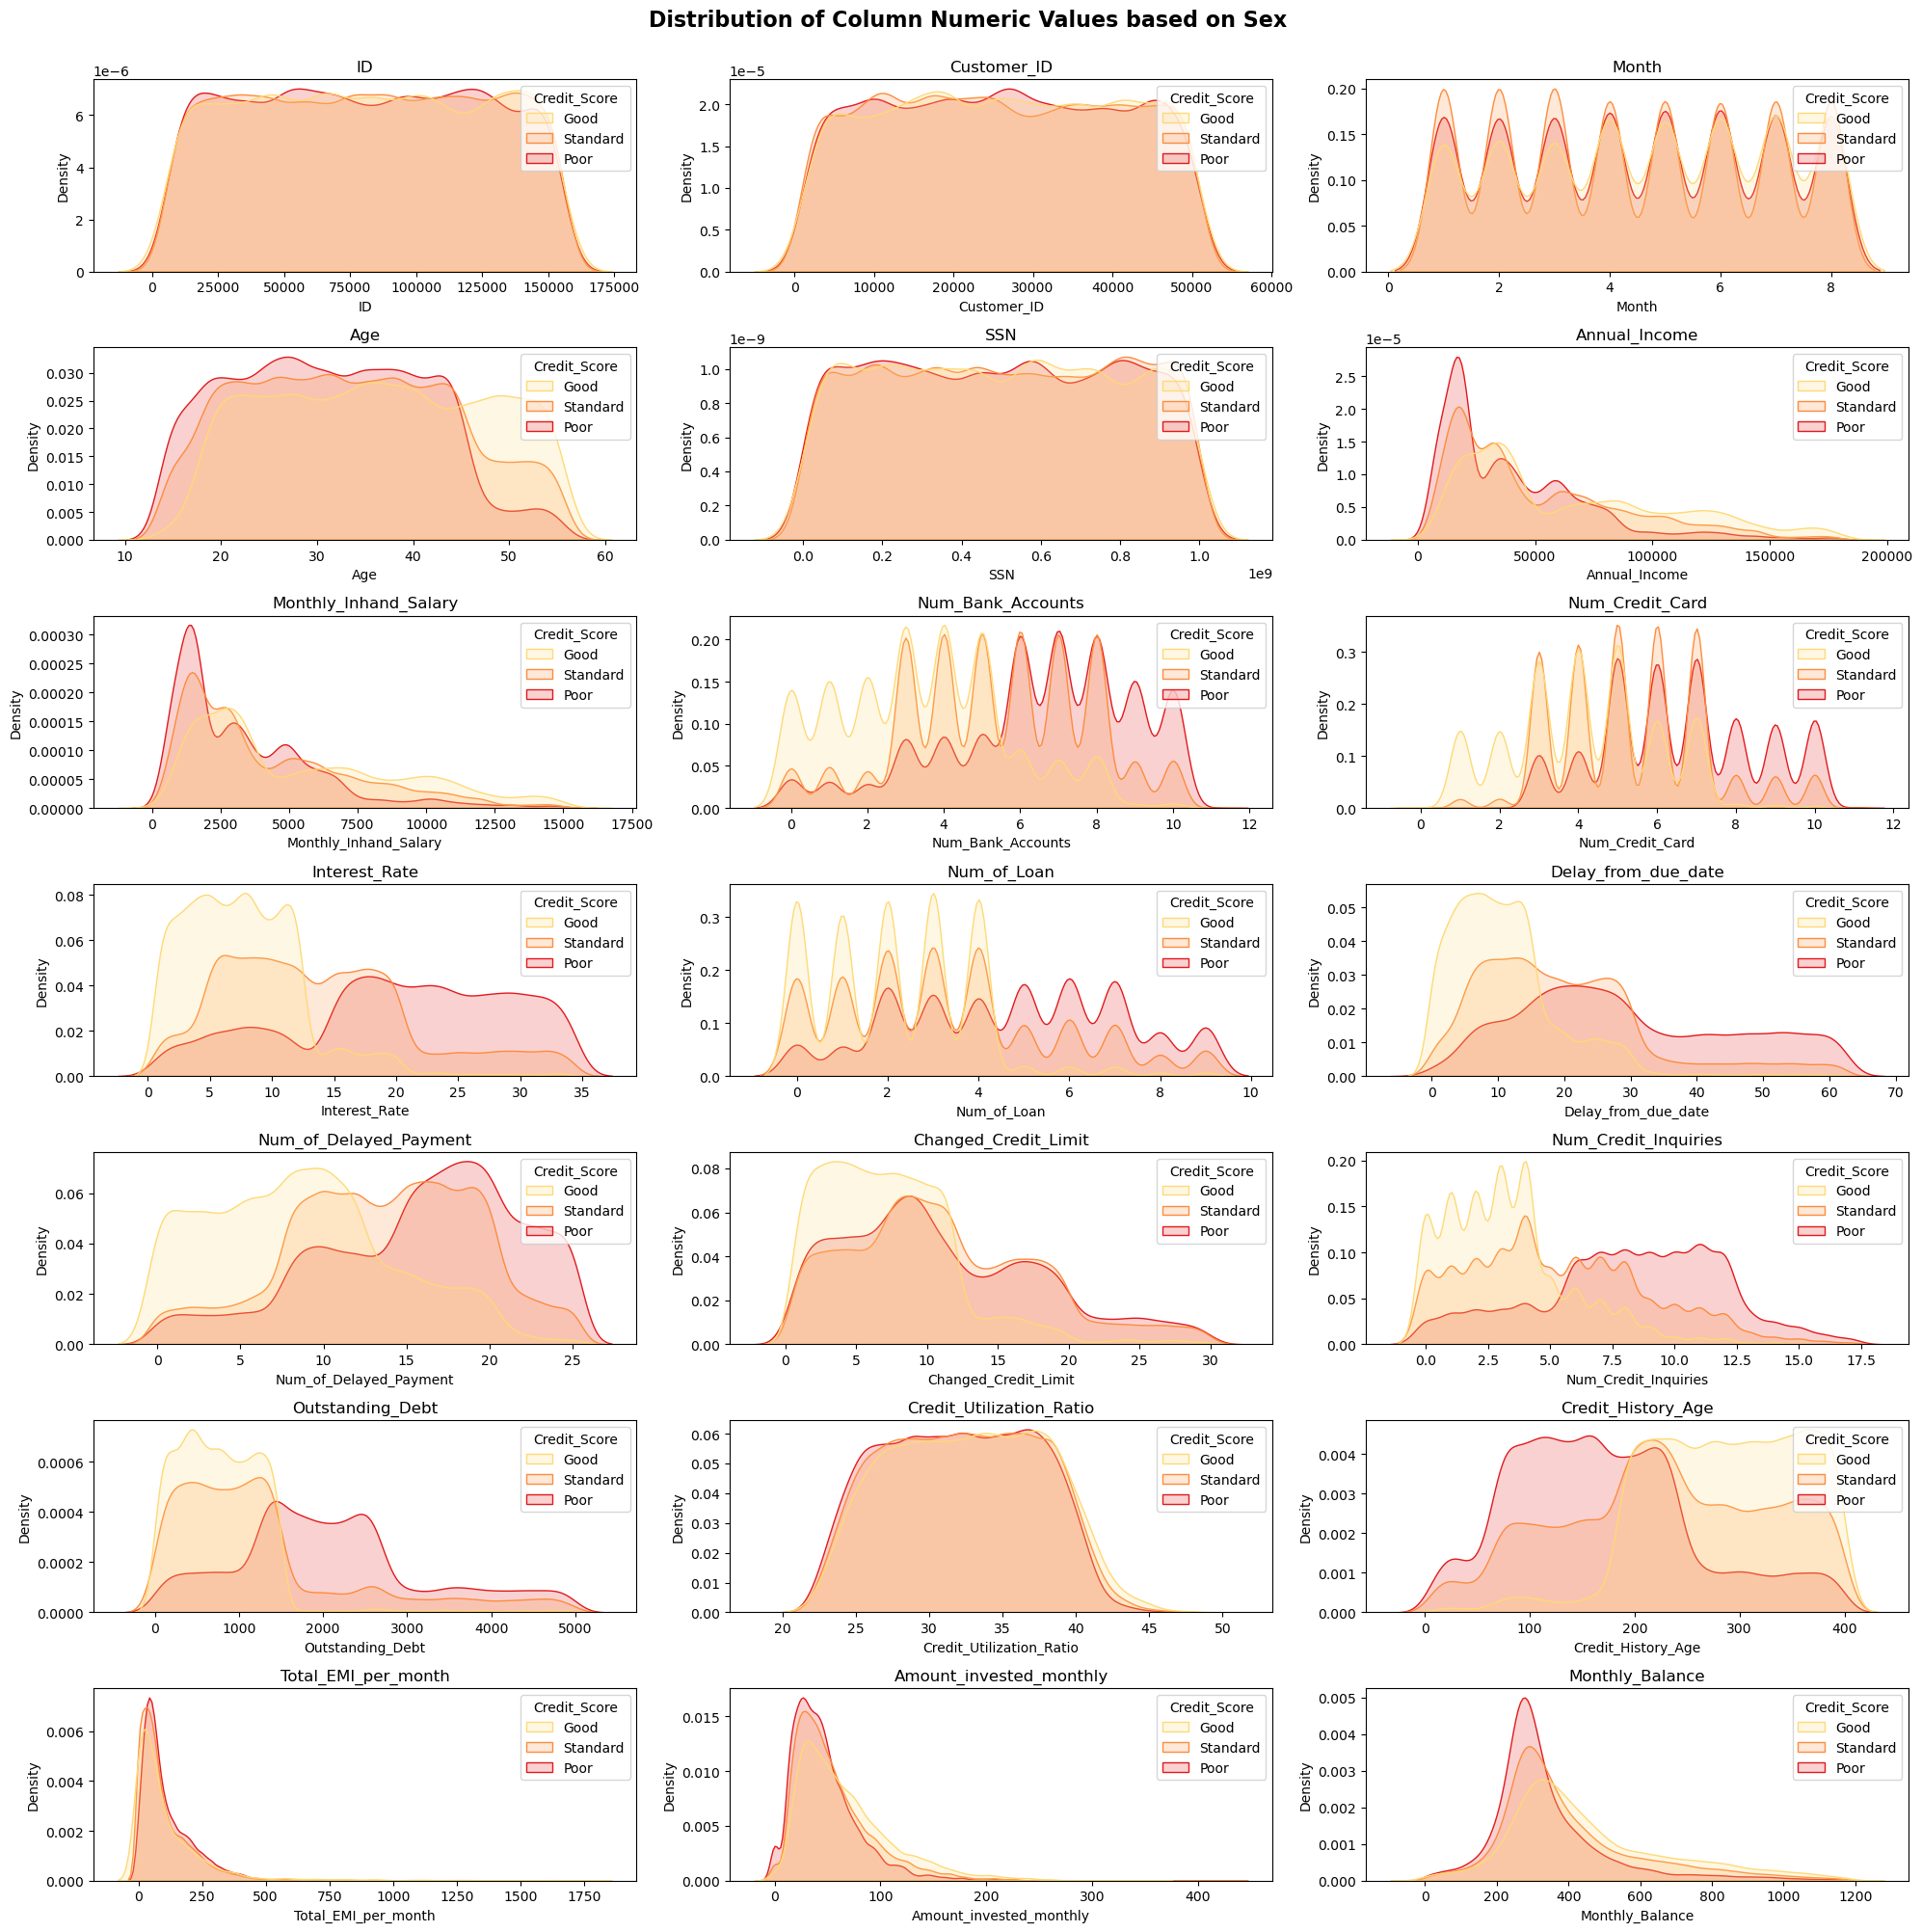

In [85]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="Credit_Score", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col])\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Sex', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

[Text(0, 0, '17828'), Text(0, 0, '53174'), Text(0, 0, '28998')]

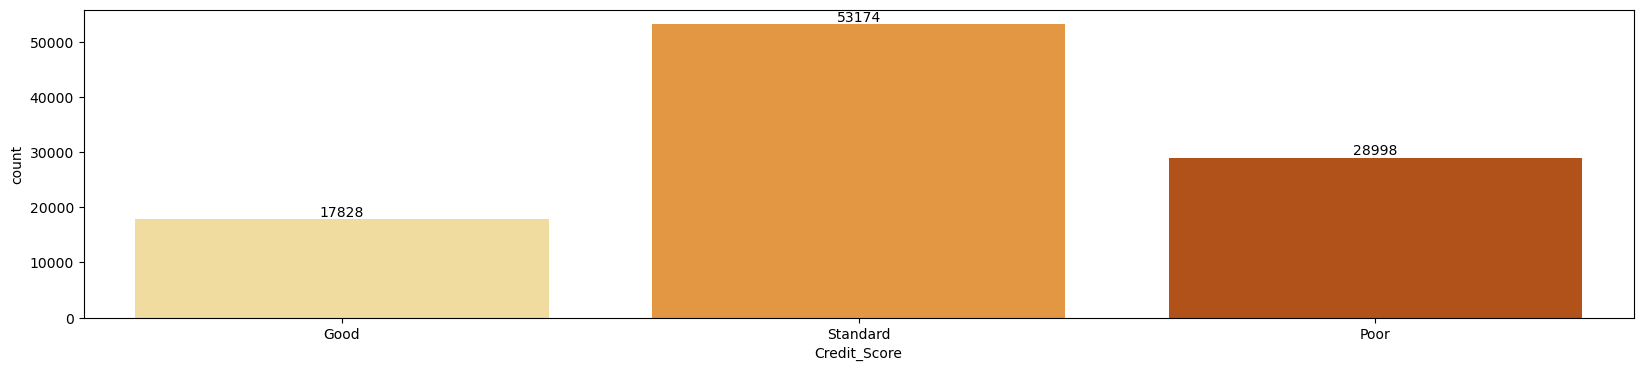

In [86]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'Credit_Score', palette='YlOrBr')
ax.bar_label(ax.containers[0])

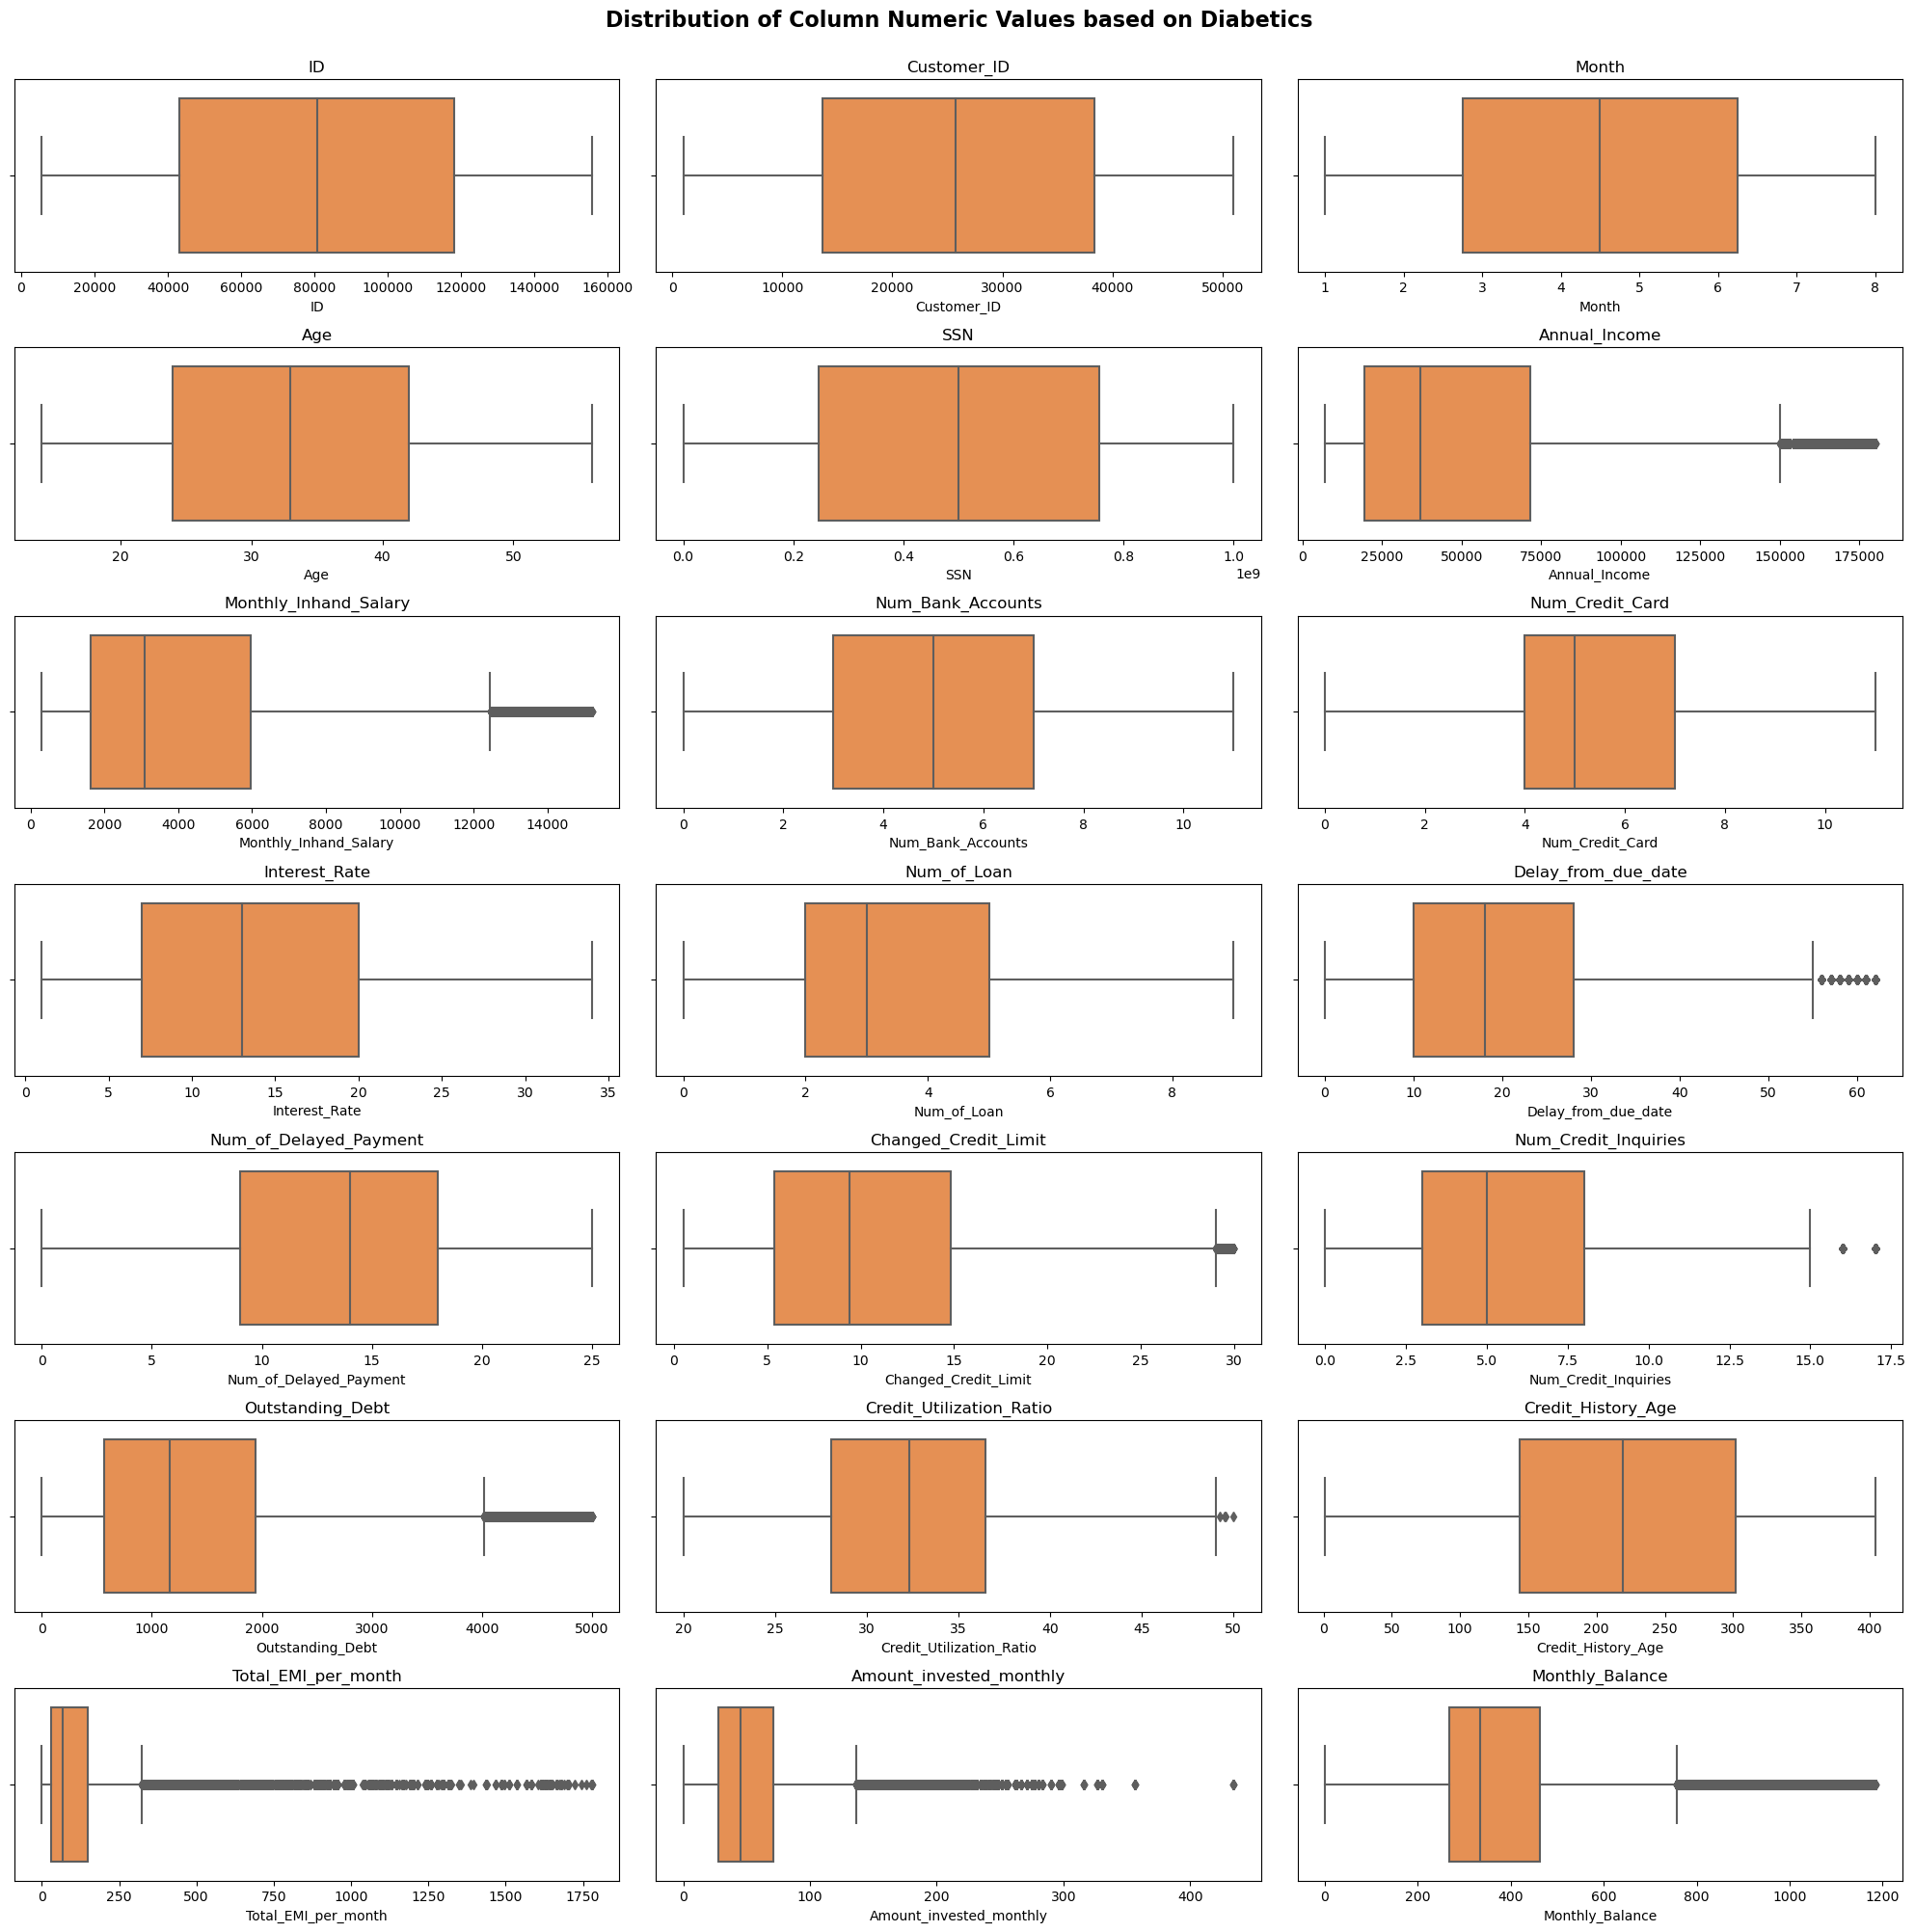

In [131]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

In [5]:
# data_copy = data.copy()
# encoder = LabelEncoder()

# data_copy['Occupation'] = encoder.fit_transform(data_copy['Occupation'])
# data_copy['Credit_Mix'] = encoder.fit_transform(data_copy['Credit_Mix'])
# data_copy['Payment_of_Min_Amount'] = encoder.fit_transform(data_copy['Payment_of_Min_Amount'])
# data_copy['Payment_Behaviour'] = encoder.fit_transform(data_copy['Payment_Behaviour'])
# data_copy['Credit_Score'] = encoder.fit_transform(data_copy['Credit_Score'])


Text(0.5, 1.0, 'Correlation Matrix')

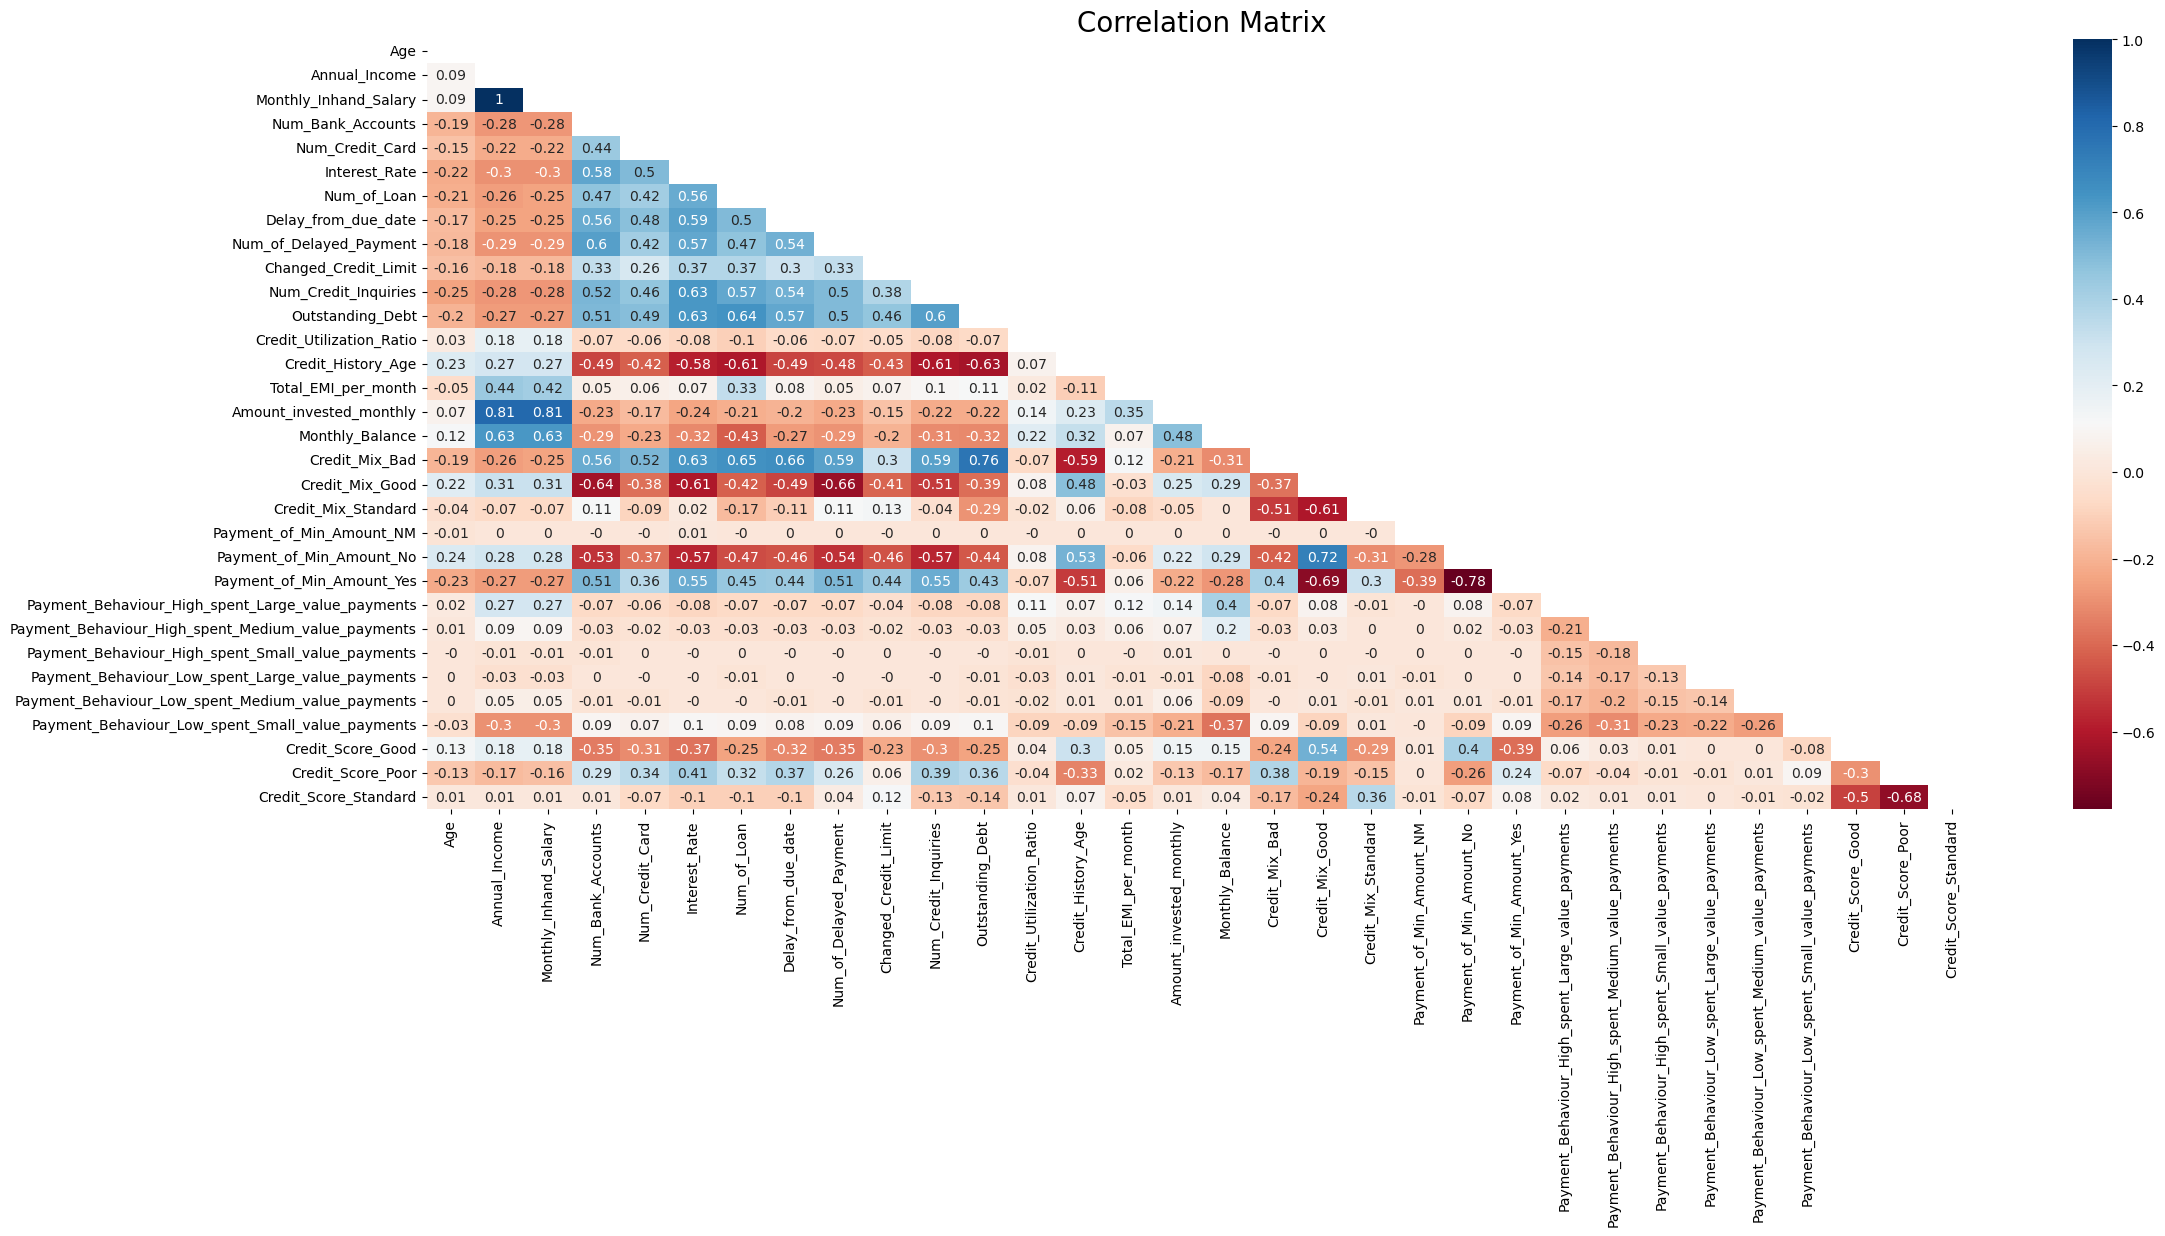

In [8]:
feature = data.drop(columns=['ID','Customer_ID','Month','SSN','Name', 'Type_of_Loan', 'Occupation'])

data_copy = pd.get_dummies(feature)

corr_data = data_copy.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(25, 10))
sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Labeling and Change Dtypes

In [229]:
# data['Credit_Score'] = data['Credit_Score'].map({'Good' : 2,
#                                                        'Standard' : 1,
#                                                        'Bad' : 0})

# encoder = LabelEncoder()

# data['Occupation'] = encoder.fit_transform(data['Occupation'])
# data['Credit_Mix'] = encoder.fit_transform(data['Credit_Mix'])
# data['Payment_of_Min_Amount'] = encoder.fit_transform(data['Payment_of_Min_Amount'])
# data['Payment_Behaviour'] = encoder.fit_transform(data['Payment_Behaviour'])
# data['Credit_Score'] = encoder.fit_transform(data['Credit_Score'])

In [39]:
# data = data.drop(columns=['ID','Customer_ID','Month','SSN','Name', 'Type_of_Loan', 'Credit_Score'])

# data = pd.get_dummies(data)
# data.head(5)

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,11.27,...,0,0,1,0,0,0,1,0,0,0
1,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,4.0,11.27,...,0,0,1,0,0,0,0,1,0,0
2,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,11.27,...,0,0,1,0,0,0,0,0,1,0
3,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,6.27,...,0,0,1,0,0,0,0,0,0,1
4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,11.27,...,0,0,1,0,0,1,0,0,0,0


### 4.2. Features Selections

In [11]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [12]:
X = data.drop(columns=['ID','Customer_ID','Month','SSN', 'Occupation','Name', 'Type_of_Loan','Credit_Score'])
Y = data['Credit_Score']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### 4.2. Splitting Train, Test, And Validation data 

In [13]:
# X = data.drop(columns=['ID','Customer_ID','Month','SSN','Name', 'Type_of_Loan','Credit_Score'])
# X = data.drop(columns=['Credit_Score'])
# Y = data['Credit_Score']

feature = data.drop(columns=['ID','Customer_ID','Month','SSN','Name', 'Type_of_Loan', 'Credit_Score'])

X = pd.get_dummies(feature)

# Y = data['Credit_Score'].map({'Good' : 2, 'Standard' : 1, 'Poor' : 0})
encoder = LabelEncoder()
Y = encoder.fit_transform(data['Credit_Score'])

print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_val = scalar.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Counter({2: 53174, 1: 28998, 0: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 44)
(10590, 44)
(5349, 44)
(37545, 3)
(10590, 3)
(5349, 3)


### 4.3. Neural Network Algoritms

In [14]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

# def GRU_Model():
#     model = Sequential()
#     model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
#     model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
#     model.add(Dense(128, activation='relu'))
#     # model.add(Dropout(0.5))
#     model.add(Dense(3, activation='softmax'))
#     return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model
    
# def GRU_Model():
#     gru_model = Sequential()
#     gru_model.add(GRU(units=32, input_shape=(X_train.shape[1], 1), 
#                 activation='tanh',recurrent_activation='sigmoid',recurrent_dropout=0.0,unroll=False, reset_after=True,))
#     gru_model.add(Dense(units=2))
#     gru_model._name = 'GRU_Model'
#     return gru_model

# model = DNN_Model()
model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 42, 128)           512       
                                                                 
 batch_normalization_2 (Batc  (None, 42, 128)          512       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 42, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 64)            24640     
                                                                 
 batch_normalization_3 (Batc  (None, 19, 64)          

In [15]:
num_epoch = 10
batch_size = 64

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/10
587/587 [==============================] - 7s 7ms/step - loss: 0.8609 - accuracy: 0.6931 - val_loss: 0.8164 - val_accuracy: 0.7162
Epoch 2/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7979 - accuracy: 0.7170 - val_loss: 0.7898 - val_accuracy: 0.7253
Epoch 3/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7761 - accuracy: 0.7238 - val_loss: 0.7823 - val_accuracy: 0.7228
Epoch 4/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7619 - accuracy: 0.7267 - val_loss: 0.7747 - val_accuracy: 0.7276
Epoch 5/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7487 - accuracy: 0.7306 - val_loss: 0.7639 - val_accuracy: 0.7294
Epoch 6/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7376 - accuracy: 0.7342 - val_loss: 0.7631 - val_accuracy: 0.7291
Epoch 7/10
587/587 [==============================] - 4s 6ms/step - loss: 0.7273 - accuracy: 0.7358 - val_loss: 0.7572 - val_accuracy: 0.7303
Epoch 

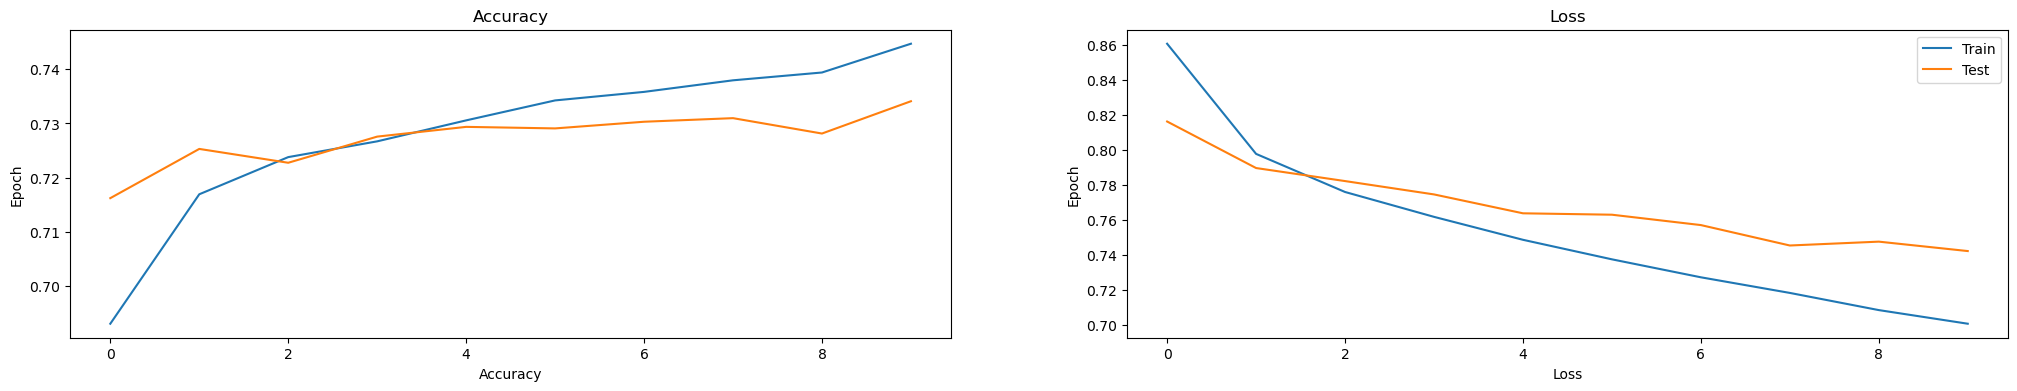

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [17]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val))

print(classification_report(y_val.argmax(axis=1),y_pred.argmax(axis=1)))

168/168 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1778
           1       0.76      0.76      0.76      1804
           2       0.72      0.57      0.63      1767

    accuracy                           0.72      5349
   macro avg       0.72      0.72      0.72      5349
weighted avg       0.72      0.72      0.72      5349



In [19]:
y_pred.argmax(axis=1)

array([2, 0, 1, ..., 0, 2, 0], dtype=int64)

In [20]:
y_pred.argmax(axis=1)

array([2, 0, 1, ..., 0, 2, 0], dtype=int64)

In [ ]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_val))
# Build confusion matrix
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 4.4. Supervised Learning

In [85]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=0)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTress', extraTrees),
    ('gradient', gradient),
    # ('randomforest', randomForest),
    # ('histGradientBoosting', histGradientBoosting),
    # ('XGB', XGB),
    # ('knn', knn),
    # ('decisionTree', decisionTree),

], n_jobs=-1)

In [86]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('gradient',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=100,
                                                           random_state=0))],
                   n_jobs=-1)

In [87]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')
print("Val Score   : ",round((model.score(X_val, y_val)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  74.38 %
Val Score   :  75.75 %


In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      3510
           1       0.78      0.78      0.78      3584
           2       0.63      0.62      0.62      3496

    accuracy                           0.73     10590
   macro avg       0.73      0.73      0.73     10590
weighted avg       0.73      0.73      0.73     10590



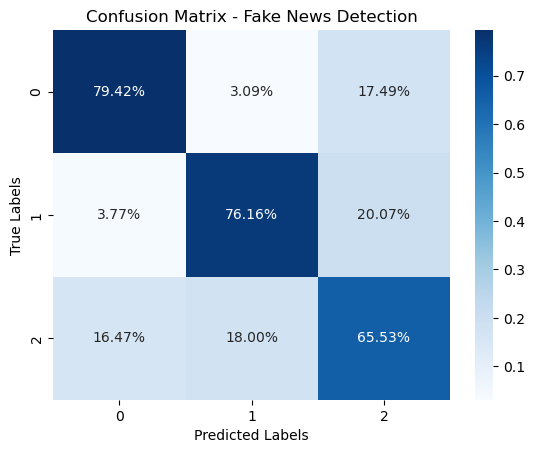

In [72]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_val))
# Build confusion matrix
con_mat = confusion_matrix(y_val,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()